In [1]:
# !pip install tensorflow-gpu==2.0.0-beta1

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import pathlib
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Compatibility operations
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
print('Version: {}'.format(tf.VERSION))

Version: 1.13.1


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
# Organizing paths of data locations
main_path = pathlib.Path(r"C:\Users\Toby-PC\Documents\code\oct\input")
train_path = main_path / 'train'
test_path = main_path / 'test'
val_path = main_path / 'val'

#### Getting a list of paths to all images.

In [27]:
import random
train_image_paths = [str(path) for path in list(train_path.glob('*/*.jpeg'))]
random.shuffle(train_image_paths)
test_image_paths = [str(path) for path in list(test_path.glob('*/*.jpeg'))]
val_image_paths = [str(path) for path in list(val_path.glob('*/*.jpeg'))]


print('Number of training images:', len(train_image_paths))
print('Number of testing images:', len(test_image_paths))
print('Number of validation images:', len(val_image_paths))

Number of training images: 83484
Number of testing images: 968
Number of validation images: 32


#### Extracting label names from parent directories and mapping to integer

In [28]:
label_names = sorted(set(item.name for item in train_path.glob('*') if item.is_dir()))
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

#### Extracting label IDs for all corpora

In [29]:
train_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in train_image_paths]
test_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in test_image_paths]
val_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in val_image_paths]

print("First 10 labels indices: ", train_image_labels[:10])

First 10 labels indices:  [0, 0, 0, 0, 0, 0, 3, 2, 0, 0]


#### Let's look at an example image.

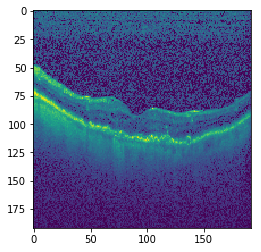

In [30]:
ex_im = tf.read_file(train_image_paths[0])
ex_im = tf.image.decode_jpeg(ex_im, channels=1)
ex_im = tf.image.resize_images(ex_im, [192, 192])

plt.imshow(ex_im[:, :, 0])

#### Data loading, resizing and rescaling

In [11]:
target_im_size = [256, 256]

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize_image_with_crop_or_pad(image, 496, 496) # First crop center square of image (some have extra left/right pixels)
    image = tf.image.resize_images(image, target_im_size) # Resize to final dimensions
    image /= 255.0  
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

#### Creating path datasets from which image datasets can be made.

In [31]:
# Path datasets
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
val_path_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)


# Image datasets
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
val_image_ds = val_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# Label datasets
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_labels, tf.int64))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_labels, tf.int64))
val_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_image_labels, tf.int64))


# Datasets with both images and labels
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
val_image_label_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))

In [13]:
print('image shape: ', train_image_label_ds.output_shapes[0])
print('label shape: ', train_image_label_ds.output_shapes[1])
print('types: ', train_image_label_ds.output_types)
print()
print(train_image_label_ds)

image shape:  (256, 256, 1)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((256, 256, 1), ()), types: (tf.float32, tf.int64)>


In [32]:
BATCH_SIZE = 64

train_ds = train_image_label_ds.shuffle(buffer_size=400) # Shuffles datasets
train_ds = train_ds.repeat() # Creates datasets iterator
train_ds = train_ds.batch(BATCH_SIZE) # Batches dataset
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Allows dataset to prefetch batches while training for performance

# Repeat for testing dataset
test_ds = test_image_label_ds.shuffle(buffer_size=200)
test_ds = test_ds.repeat()
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Repeat for validation dataset
val_ds = val_image_label_ds.shuffle(buffer_size=200)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### Construct the CNN and DNN architecture.

In [16]:
model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(*target_im_size, 1))) # CNN Layer 1
model.add(layers.MaxPooling2D((2, 2))) # Pooling layer 1

model.add(layers.Conv2D(64, (5, 5), activation='relu')) # CNN Layer 2
model.add(layers.MaxPooling2D((2, 2))) # Pooling layer 2

model.add(layers.Conv2D(128, (5, 5), activation='relu')) # CNN Layer 3
model.add(layers.Flatten()) # Flattening layer

model.add(layers.Dense(64, activation='relu')) # Fully-connected layer "on top"
model.add(layers.Dropout(0.2))

model.add(layers.Dense(4, activation='softmax')) # Softmax output from logits

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Look at overall architecture of NN

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 128)       204928    
_________________________________________________________________
flatten (Flatten)            (None, 415872)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                26615872  
__________

In [18]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [23]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [24]:
EPOCHS = 1
model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=len(train_image_paths)//BATCH_SIZE, callbacks=[checkpoint_callback])

1303/1304 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9885WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x0000029C213F9400>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
1304/1304 [==============================] - 128s 98ms/step - loss: 0.0333 - acc: 0.9885


In [25]:
test_loss, test_acc = model.evaluate(test_ds, steps=len(test_image_paths))

968/968 [==============================] - 37s 38ms/step - loss: 0.1684 - acc: 0.9721


In [26]:
print('Model Accuracy on Test Data: {:.1f}%'.format(test_acc * 100))

Model Accuracy on Test Data: 97.2%


In [33]:
test_loss, test_acc = model.evaluate(val_ds, steps=len(val_image_paths))

32/32 [==============================] - 1s 40ms/step - loss: 0.2919 - acc: 0.9688
